In [48]:
# Relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Ben_s_Analysis.FunkEquations import Funk_Equation_LowPPM

In [49]:
# Loading in Data:
data = pd.read_csv("/Users/benfunk/DataspellProjects/MethaneDataScience/Output/FullVOMatrix.csv")

In [50]:
#calculate absolute humidity in g/m^3
e_sat_standard = 6.112 * np.exp((17.67 * data['Temperature']) / (data['Temperature'] + 243.5))
actual_pressure = data['RelativeHumidity'] * e_sat_standard
xDataAH = (18.02*actual_pressure)/(100*(data['Temperature']+ 273.15)*0.08314)
data['ActualHumidity'] = xDataAH
data['Target PPM'] = data['Target PPM'] + 4.16

In [51]:
# Apply the Funk_Equation_LowPPM to each row to calculate 'Calculated PPM'
data['Calculated PPM'] = data.apply(lambda row: Funk_Equation_LowPPM((row['Resistance'], row['ActualHumidity'], row['Temperature'])), axis=1)

In [53]:
# p0 = [0.711201, 0.071861, -14.961631, 0.000950, -5.994732, 2.459324, -0.000266, 2.459146, -16.168544, -1.855425]
# import scipy.optimize as sc
# def funkEQ(X, a, b, c, d, e, f, g, h, i, j):
#     R, H, T = X
#     with np.errstate(over='ignore'):
#         stuff = a**((((-1*R)/(H**b))*c)+(-1*H*d)+(-1*T*e)+(((-1*T*f)/(H**g))*h)+i) + j
#     return stuff
#
# popt, _ = sc.curve_fit(funkEQ, (data['Resistance'], data['ActualHumidity'], data['Temperature']), data['Target PPM'], p0, maxfev=1000000)
#
# param_names = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l','m','n','o','p','q','r','s','t','u','v','w']
# print(' '.join(f'{name} = {value:.6f}' for name, value in zip(param_names, popt)))
#
# data['Calculated PPM'] = data.apply(lambda row: funkEQ((row['Resistance'], row['ActualHumidity'], row['Temperature']),*popt), axis=1)

a = 0.369232 b = 0.111613 c = -4.714868 d = -0.003684 e = -6.026000 f = 2.455307 g = 0.000230 h = 2.455943 i = -5.899531 j = -2.571275


/var/folders/1g/qs1wt1d52t1fp_9wj2_z6vlr0000gn/T/ipykernel_50777/3488057525.py:6: RuntimeWarning: invalid value encountered in power
  stuff = a**((((-1*R)/(H**b))*c)+(-1*H*d)+(-1*T*e)+(((-1*T*f)/(H**g))*h)+i) + j


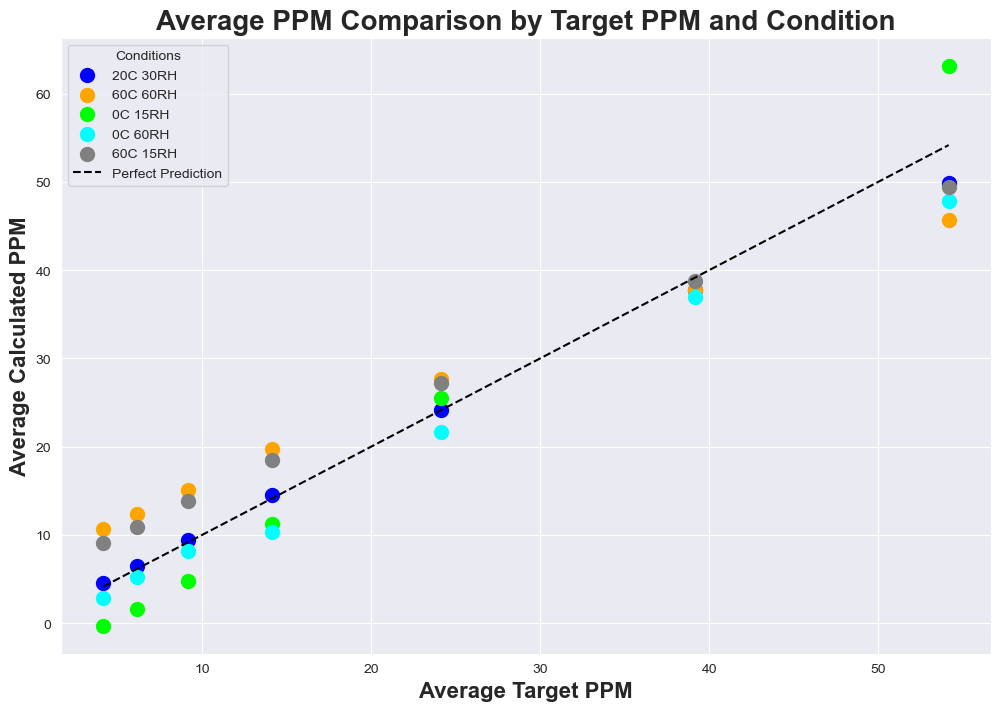

In [54]:
# Adjusting conditions to group them within a range of +-5
'''
Blue 20C 30RH (ambient)
Orange 60C 60RH (hot/humid)
Lime 0C 15RH (cold and dry)
Cyan 0C 60RH
Grey 60C 15RH
'''
conditions = [
    ((data['Temperature'] >= 10) & (data['Temperature'] <= 30) & (data['RelativeHumidity'] >= 20) & (data['RelativeHumidity'] <= 40)),  # Blue
    ((data['Temperature'] >= 50) & (data['Temperature'] <= 70) & (data['RelativeHumidity'] >= 55) & (data['RelativeHumidity'] <= 70)),  # Orange
    ((data['Temperature'] >= -10) & (data['Temperature'] <= 10) & (data['RelativeHumidity'] >= 5) & (data['RelativeHumidity'] <= 25)),   # Lime
    ((data['Temperature'] >= -10) & (data['Temperature'] <= 10) & (data['RelativeHumidity'] >= 50) & (data['RelativeHumidity'] <= 70)),   # Cyan
    ((data['Temperature'] >= 50) & (data['Temperature'] <= 70) & (data['RelativeHumidity'] >= 10) & (data['RelativeHumidity'] <= 23))   # Grey
]

# Assigning labels based on the conditions
labels = ['20C 30RH', '60C 60RH', '0C 15RH', '0C 60RH', '60C 15RH']
data['Label'] = np.select(conditions, labels, default='Other')

# Assigning colors based on the same conditions
colors = ['blue', 'orange', 'lime', 'cyan', 'gray']
data['Color'] = np.select(conditions, colors, default='black')

# Grouping data by Target PPM and Label, then calculating the mean for each group
mean_data = data.groupby(['Target PPM', 'Label', 'Color']).mean().reset_index()

# Setting up the plot
plt.figure(figsize=(12, 8))

# Plotting mean points for each Target PPM and condition
for label, color in zip(labels, colors):
    subset = mean_data[mean_data['Label'] == label]
    plt.scatter(subset['Target PPM'], subset['Calculated PPM'], c=color, label=label, s=100)  # s is the size of the points

# Adding the y=x line to represent perfect prediction
plt.plot([data['Target PPM'].min(), data['Target PPM'].max()], [data['Target PPM'].min(), data['Target PPM'].max()], 'k--', label='Perfect Prediction')

# Adding labels, title, and legend
plt.xlabel('Average Target PPM', fontsize=16, fontweight='bold')
plt.ylabel('Average Calculated PPM', fontsize=16, fontweight='bold')
plt.title('Average PPM Comparison by Target PPM and Condition', fontsize=20, fontweight='bold')
plt.legend(title='Conditions')

# Show the plot
plt.show()

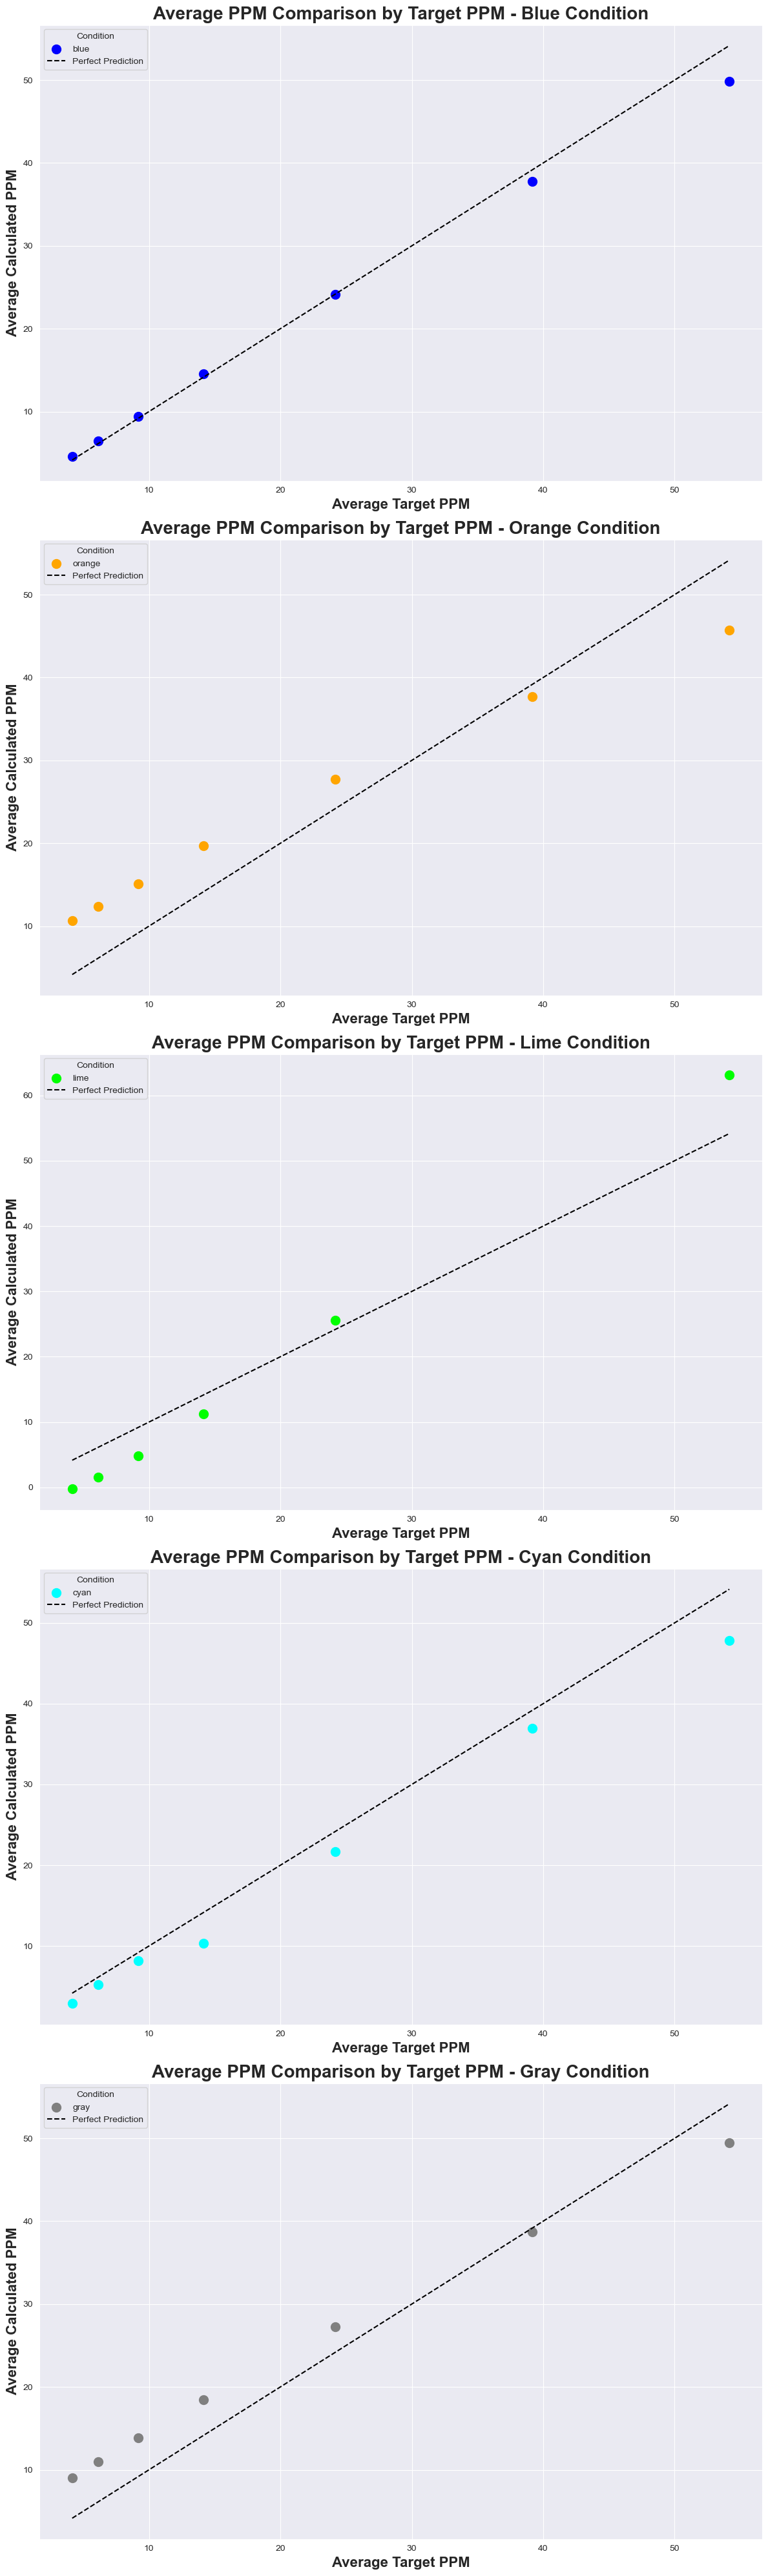

In [55]:
# Setting up multiple plots for each color (condition)
fig, axes = plt.subplots(len(colors), 1, figsize=(12, 8 * len(colors)))

# Plotting mean points for each Target PPM and condition on separate plots
for idx, color in enumerate(colors):
    subset = mean_data[mean_data['Color'] == color]
    axes[idx].scatter(subset['Target PPM'], subset['Calculated PPM'], c=color, label=color, s=100)  # s is the size of the points

    # Adding the y=x line to represent perfect prediction
    axes[idx].plot([data['Target PPM'].min(), data['Target PPM'].max()], [data['Target PPM'].min(), data['Target PPM'].max()], 'k--', label='Perfect Prediction')

    # Adding labels and title to each subplot
    axes[idx].set_xlabel('Average Target PPM', fontsize=16, fontweight='bold')
    axes[idx].set_ylabel('Average Calculated PPM', fontsize=16, fontweight='bold')
    axes[idx].set_title(f'Average PPM Comparison by Target PPM - {color.capitalize()} Condition', fontsize=20, fontweight='bold')

    # Adding legend to each subplot
    axes[idx].legend(title='Condition')

# Adjusting layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()
